# Anomaly Detection across Multiple Farms

## NDVI Calculation

In [13]:
!pip install rasterio
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from xml.dom import minidom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 36.0 MB/s eta 0:00:00


In [14]:
imgFile = 'demo.tif'
xmlFile = 'demo.xml'

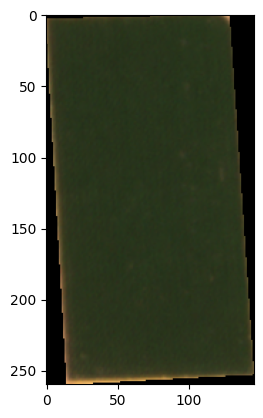

In [15]:
with rasterio.open(imgFile) as src:
    band_blue = src.read(1)
    band_green = src.read(2)
    band_red = src.read(3)
    band_nir = src.read(4)
#     band_red = src.read(1)
#     band_blue = src.read(3)
#     band_green = src.read(2)
#     band_nir = src.read(4)
    rgb = np.dstack((band_red, band_green, band_blue))
    rgb_norm = rgb / np.max(rgb)
    plt.imshow(rgb_norm) #printing the rgb image for the given demo tiff file
    plt.show()

In [16]:
xmldoc = minidom.parse(xmlFile)
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")
# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [17]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [18]:
np.nanmin(ndvi), np.nanmax(ndvi)
currNdvi = np.nanmean(ndvi)
print(currNdvi)

0.8476803194252116


In [19]:
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

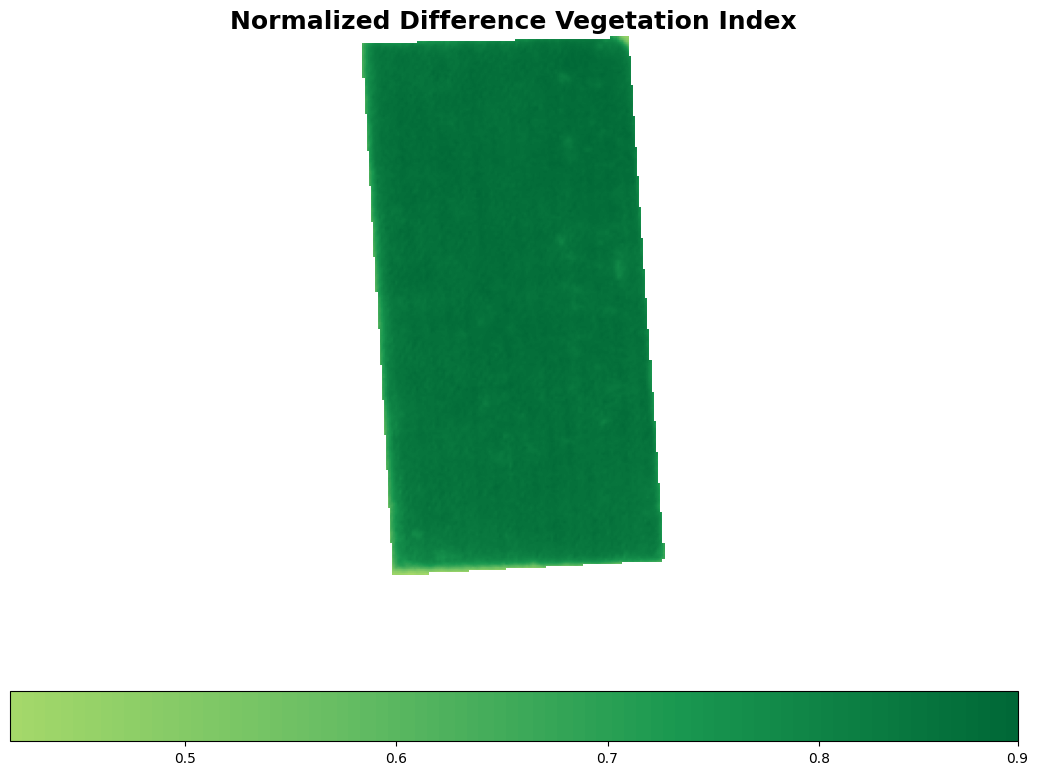

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

## Analyzing NDVI time series dataset

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

#df = pd.read_csv('Wheat_farms_NDVI_data.csv')
df = pd.read_csv('Wheat_farms_NDVI_data.csv', parse_dates=True)

df_ = df.copy()
df_[['date','sowing date']] = df_[['date','sowing date']].apply(pd.to_datetime) #if conversion required
df_['number_of_days'] = (df_['date'] - df_['sowing date']).dt.days
df_

,scene_id,sowing date,date,min,max,average,std,variance,median,number_of_days
0,farm1,2020-11-20,2020-11-20,0.1453,0.2392,0.1942,0.0191,0.0004,0.1928,0
1,farm1,2020-11-20,2020-12-15,0.3890,0.5553,0.4961,0.0387,0.0015,0.5067,25
2,farm1,2020-11-20,2020-12-25,0.4415,0.6175,0.5619,0.0395,0.0016,0.5696,35
3,farm1,2020-11-20,2021-01-27,0.6683,0.7644,0.7439,0.0174,0.0003,0.7501,68
4,farm1,2020-11-20,2021-02-08,0.6806,0.7523,0.7292,0.0147,0.0002,0.7339,80
...,...,...,...,...,...,...,...,...,...,...
407,farm13,2022-11-18,2023-02-03,0.6551,0.7397,0.7083,0.0183,0.0003,0.7107,77
408,farm13,2022-11-18,2023-02-13,0.7219,0.8001,0.7753,0.0156,0.0002,0.7778,87
409,farm13,2022-11-18,2023-02-26,0.6676,0.7165,0.6886,0.0111,0.0001,0.6871,100
410,farm13,2022-11-18,2023-03-08,0.6601,0.7034,0.6845,0.0108,0.0001,0.6832,110


In [2]:
#df_[df_['scene_id']=='farm1']
df_[df_['number_of_days'] == 25]

,scene_id,sowing date,date,min,max,average,std,variance,median,number_of_days
1,farm1,2020-11-20,2020-12-15,0.3890,0.5553,0.4961,0.0387,0.0015,0.5067,25
120,farm5,2020-11-13,2020-12-08,0.1697,0.3778,0.2789,0.0511,0.0026,0.2859,25
153,farm6,2020-11-13,2020-12-08,0.2800,0.4107,0.3514,0.0304,0.0009,0.3562,25


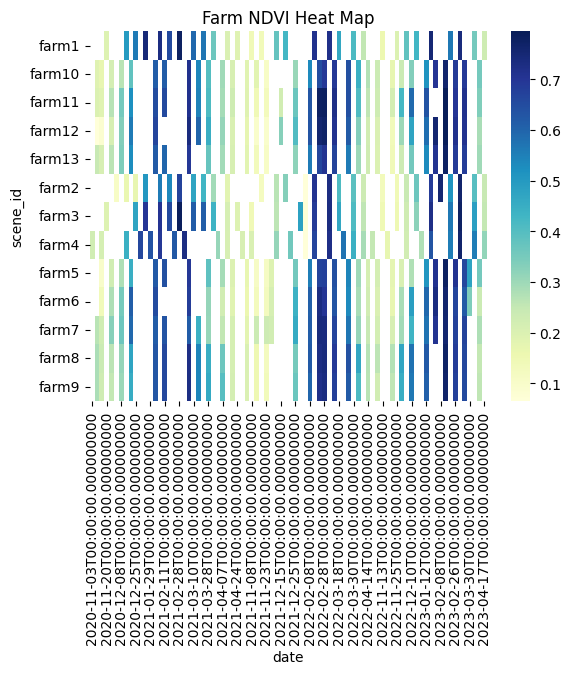

In [3]:
import seaborn as sns
# Create a pivot table
pivot_table = df_.pivot(index='scene_id', columns='date', values='average')

# Create a heat map using seaborn's heatmap function
sns.heatmap(pivot_table, cmap='YlGnBu')

# Set the title of the plot
plt.title('Farm NDVI Heat Map')

# Show the plot
plt.show()

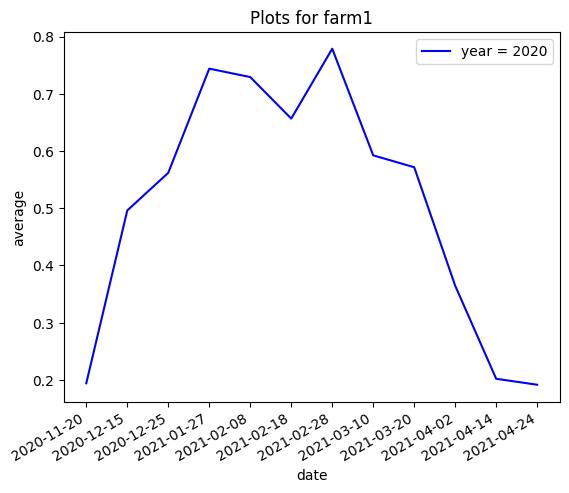

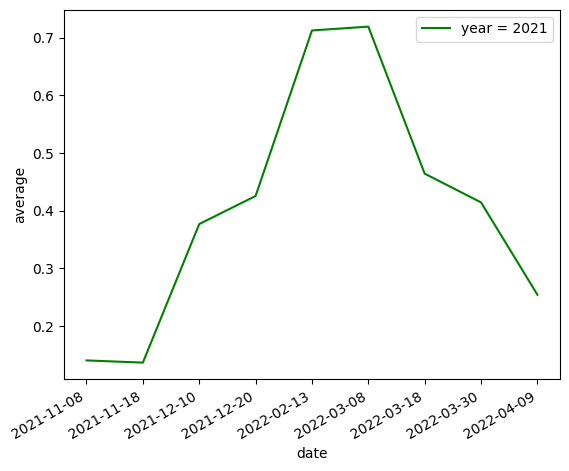

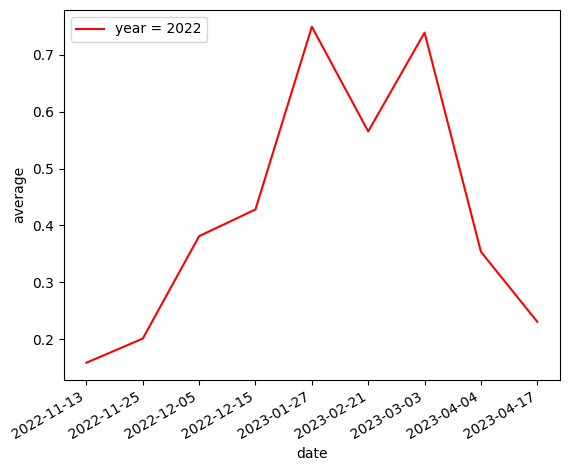

In [4]:
from datetime import datetime
from sklearn.model_selection import train_test_split

#df1 = df[(df['date'] > '2020-11-01') & (df['date'] <= '2021-04-30')]
#for i in 
i = df.scene_id.unique()[0]
df_yr1 = df[(df['scene_id'] == i) & (df['date'] > '2020-11-01') & (df['date'] <= '2021-04-30')]
df_yr2 = df[(df['scene_id'] == i) & (df['date'] > '2021-11-01') & (df['date'] <= '2022-04-30')]
df_yr3 = df[(df['scene_id'] == i) & (df['date'] > '2022-11-01') & (df['date'] <= '2023-04-30')]

fig, ax = plt.subplots()
plt.title("Plots for {}".format(i))
plt.plot(df_yr1["date"], df_yr1["average"], color = "b", label="year = 2020")
plt.legend()
plt.xlabel("date")
plt.ylabel("average")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()
fig, ax = plt.subplots()
plt.plot(df_yr2["date"], df_yr2["average"], color = "g", label="year = 2021")
plt.legend()
plt.xlabel("date")
plt.ylabel("average")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()
fig, ax = plt.subplots()
plt.plot(df_yr3["date"], df_yr3["average"], color = "r", label="year = 2022")
plt.legend()
plt.xlabel("date")
plt.ylabel("average")
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
plt.show()

print("\n")

X_train, X_test, y_train, y_test = train_test_split(df_["number_of_days"], df_["average"], test_size = 0.2)

## DBSCAN

In [5]:
#DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.cluster import DBSCAN

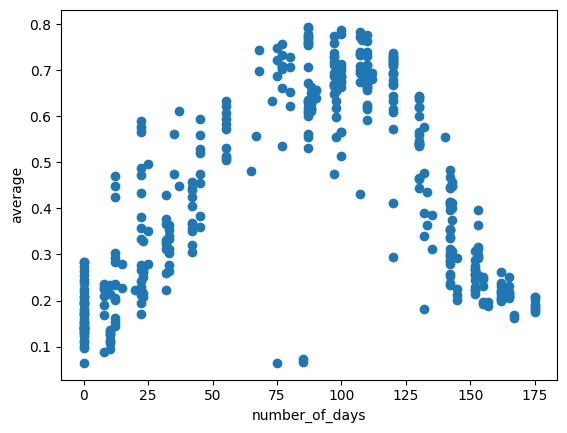

In [6]:
plt.scatter(df_["number_of_days"], df_["average"])
plt.xlabel("number_of_days")
plt.ylabel("average")
plt.show()

In [21]:
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
model = scaler.fit(df_[['number_of_days','average']])
df1 = model.transform(df_[['number_of_days','average']])
max_cols = df_.max(axis=0)[["number_of_days", "average"]]
min_cols = df_.min(axis=0)[["number_of_days", "average"]]
print(max_cols, min_cols)

db_default = DBSCAN(eps = 0.07, min_samples = 5).fit(df1)
labels = db_default.labels_
print(labels)

number_of_days       175
average           0.7945
dtype: object number_of_days         0
average           0.0648
dtype: object
[ 0  0  0  1  1  1  1  1  1  2  2  2  0  0  0  0  1  1  2  2  2  0  0  0
  0  1  1  1  2  2  0  0  0  0  1  1  1 -1 -1 -1 -1  0  0  0 -1  1  1 -1
  2  2  0  0  0  0  1  1  1  1  2  2  0  0  1  1  1  1  1  1  2  2  2  0
  0  0 -1  1  1  2  2  2  0  0  0  0  1  1  1  2  2  0  0  0  1  1  1  1
  1  2  2  2  0  0  0 -1  1  1  1  2  2  2  0  0  0  1  1  1  1  2  0  0
  0  0  1  1  1  2  2  2  2  0  0  0  0  1  1  1  1  1  2  2  2  0  0  0
  0  1  1  1  1  2  2  0  0  0  0  1  1  2  2  2  2  0  0  0  0  1  1  1
  1  1  2  2  2  0  0  0  0  1  1  1  1  2  2  0  0  0  0  0  1  1  1  2
  2  2  2  2  0  0  0  0  1  1  1  1  1  2  2  2  0  0  0  0  1  1  1  1
  2  0  0  0  0  0  1  1  1  1  2  2  2  2  0  0  0  1  1  1  1  1  2  2
  2  0  0 -1  0  1  1  1  2  0  0  0  0  0  1  1  1  1  2  2  2  2  0  0
  0  1  1  1  1  1  2  2  2  0  0 -1  0  1  1  1  2  0  0  0  0  0  1

In [22]:
from sklearn import metrics
sample_cores = np.zeros_like(labels, dtype=bool)
sample_cores[db_default.core_sample_indices_]=True
print("n_cluster=",len(set(labels))-(1 if -1 in labels else 0))
if len(set(labels))!=1:
    print(metrics.silhouette_score(df_[["number_of_days","average"]],labels))

n_cluster= 3
0.5369022860090568


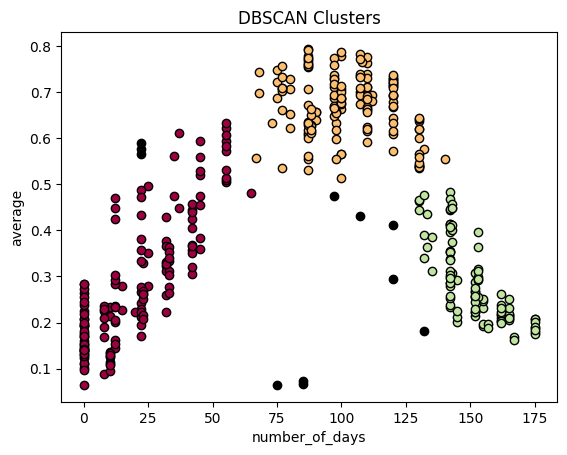

In [23]:
# Define a color map for the clusters
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))

# Create a scatter plot of the data points, colored according to cluster labels
for k, col in zip(set(labels), colors):
    if k == -1:
        # Plot noise points as black
        col = 'k'
    class_member_mask = (labels == k)
    xy = df_[class_member_mask][["number_of_days","average"]]
    plt.scatter(xy.iloc[:, 0], xy.iloc[:, 1], c=[col], edgecolors='black')

plt.title('DBSCAN Clusters')
plt.xlabel("number_of_days")
plt.ylabel("average")
plt.show()

In [24]:
# #Code to take input and generate anomalous or not
# input_ = []
# sowing_date = input("Enter sowing date (YYYY-MM-DD): ")
# current_date = input("Enter current date (YYYY-MM-DD): ")
# current_ndvi_sowing_date = datetime.strptime(sowing_date, '%Y-%m-%d')
# current_ndvi_date = datetime.strptime(current_date, '%Y-%m-%d')
# day = (current_ndvi_date - current_ndvi_sowing_date).days
# #day = float(input("Enter NDVI value: "))
# ndvi_val = float(input("Enter NDVI value: "))
# input_.append([day, ndvi_val])

# input_[0][0] = (input_[0][0] - min_cols.iloc[0])/(max_cols.iloc[0] - min_cols.iloc[0])
# input_[0][1] = (input_[0][1] - min_cols.iloc[1])/(max_cols.iloc[1] - min_cols.iloc[1])
# print(input_)

# # cluster_label = db_default.fit_predict(input_)
# # print(cluster_label)

# def predict(db, x):
#     dists = np.sqrt(np.sum((db.components_ - x)**2, axis=1))
#     #print(dists)
#     i = np.argmin(dists)
#     return db.labels_[db.core_sample_indices_[i]] if dists[i] < db.eps else -1


# if(predict(db_default, input_) == -1):
#     print("Given NDVI data is anomalous.")
# else:
#     print("Given NDVI data is not anomalous")


Enter sowing date (YYYY-MM-DD): 2022-07-08
Enter current date (YYYY-MM-DD): 2022-08-08
Enter NDVI value: 0.5
[[0.17714285714285713, 0.5964094833493216]]
Given NDVI data is not anomalous


In [25]:
# Define a function to get input from the user for each farm and predict anomalous or not
def predict_anomaly(db_default, min_cols, max_cols):
    sowing_date = input("Enter sowing date (YYYY-MM-DD): ")
    current_date = input("Enter current date (YYYY-MM-DD): ")
    current_ndvi_sowing_date = datetime.strptime(sowing_date, '%Y-%m-%d')
    current_ndvi_date = datetime.strptime(current_date, '%Y-%m-%d')
    day = (current_ndvi_date - current_ndvi_sowing_date).days
    ndvi_val = float(input("Enter NDVI value: "))

    input_ = [[day, ndvi_val]]
    input_[0][0] = (input_[0][0] - min_cols.iloc[0])/(max_cols.iloc[0] - min_cols.iloc[0])
    input_[0][1] = (input_[0][1] - min_cols.iloc[1])/(max_cols.iloc[1] - min_cols.iloc[1])

    if predict(db_default, input_) == -1:
        print("Given NDVI data is anomalous.")
    else:
        print("Given NDVI data is not anomalous")


# Predict anomalous or not for each farm
for i in range(5):
    print(f"Farm {i+1}:")
    predict_anomaly(db_default, min_cols, max_cols)


Farm 1:
Enter sowing date (YYYY-MM-DD): 2022-07-08
Enter current date (YYYY-MM-DD): 2022-08-08
Enter NDVI value: 0.3
Given NDVI data is not anomalous
Farm 2:
Enter sowing date (YYYY-MM-DD): 2022-09-07
Enter current date (YYYY-MM-DD): 2022-11-02
Enter NDVI value: 0.8
Given NDVI data is anomalous.
Farm 3:
Enter sowing date (YYYY-MM-DD): 2022-09-01
Enter current date (YYYY-MM-DD): 2022-10-01
Enter NDVI value: 0.1
Given NDVI data is anomalous.
Farm 4:
Enter sowing date (YYYY-MM-DD): 2022-01-05
Enter current date (YYYY-MM-DD): 2022-04-05
Enter NDVI value: 0.6
Given NDVI data is not anomalous
Farm 5:
Enter sowing date (YYYY-MM-DD): 2022-01-06
Enter current date (YYYY-MM-DD): 2022-06-06
Enter NDVI value: 0.23
Given NDVI data is not anomalous


### Doing grid search to obtain the best epsilon and min_sample value to get the best silhoutte score

In [26]:
from sklearn.preprocessing import MinMaxScaler
# Define parameter grid
param_grid = {
    'eps': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'min_samples': [2, 3, 4, 6, 8, 12, 16]
}

# Perform grid search
best_score = -1
best_params = None

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        

        scaler = MinMaxScaler()
        model = scaler.fit(df_[['number_of_days','average']])
        df1 = model.transform(df_[['number_of_days','average']])
        # Numpy array of all the cluster labels assigned to each data point
        db_default = DBSCAN(eps = eps, min_samples = min_samples).fit(df1)
        labels = db_default.fit_predict(df1)
        if np.unique(labels).size > 1:
            score = metrics.silhouette_score(df_[["number_of_days","average"]], labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

# Print best hyperparameters and score
print(f"Best parameters: {best_params}")
print(f"Best silhouette score: {best_score:.3f}")

Best parameters: {'eps': 0.1, 'min_samples': 16}
Best silhouette score: 0.427


## ARIMA Model

In [27]:
#ARIMA
from statsmodels.tsa.stattools import adfuller

arima_train = df_.iloc[:-60]
arima_test = df_.iloc[-60:]

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df['average'])

1. ADF :  -5.984545115546366
2. P-Value :  1.8051943246272114e-07
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 394
5. Critical Values :
	 1% :  -3.4470566389664703
	 5% :  -2.8689037160476016
	 10% :  -2.570692663557422


In [30]:
!pip install pmdarima
from pmdarima import auto_arima

stepwise_fit = auto_arima(df_['average'], trace=True, supress_warnings=True)

stepwise_fit.summary()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-659.649, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-101.801, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-409.181, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-337.688, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=568.759, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-475.095, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-597.868, Time=1.43 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-634.465, Time=2.49 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-649.769, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-438.131, Time=0.37 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-497.279, Time=0.51 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-638.115, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  412
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 335.825
Date:                Mon, 15 May 2023   AIC                           -659.649
Time:                        18:04:58   BIC                           -635.523
Sample:                             0   HQIC                          -650.106
                                - 412                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1425      0.005     26.530      0.000       0.132       0.153
ar.L1          1.6162      0.023     71.562      0.000       1.572       1.660
ar.L2         -0.9476      0.021    -44.296      0.000      -0.990      -0.906
ma.L1         -1.0568      0.035    -29.977      0.000      -1.126      -0.988
ma.L2          0.4801      0.045     10.738      0.000       0.392       0.568
sigma2         0.0114      0.001     18.841      0.000       0.010       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               148.39
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(arima_train['average'], order = (2,0,2))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                average   No. Observations:                  352
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 274.163
Date:                Mon, 15 May 2023   AIC                           -536.326
Time:                        18:05:05   BIC                           -513.144
Sample:                             0   HQIC                          -527.101
                                - 352                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4307      0.008     52.020      0.000       0.414       0.447
ar.L1          1.6059      0.026     60.988      0.000       1.554       1.657
ar.L2         -0.9419      0.025    -38.070      0.000      -0.990      -0.893
ma.L1         -1.0506      0.039    -26.856      0.000      -1.127      -0.974
ma.L2          0.4807      0.050      9.547      0.000       0.382       0.579
sigma2         0.0122      0.001     17.048      0.000       0.011       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               118.24
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

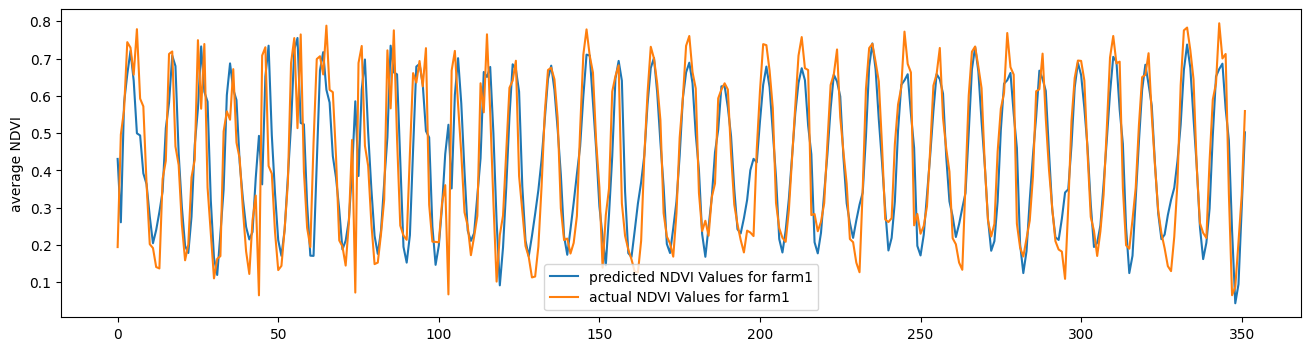

In [33]:
start_pred_index = arima_train.index[0]#len(arima_train)
end_pred_index = arima_train.index[-1]#start_pred_index + len(arima_train) -1
#current_ndvi_date = pd.to_datetime(input("Enter current NDVI date (YYYY-MM-DD): "))
pred = arima_result.predict(start = start_pred_index, end = end_pred_index, typ='levels')
#print(pred)
#pred = arima_result.predict(current_ndvi_date, current_ndvi_date)[0]
#print(pred)

plt.rcParams['figure.figsize'] = [16, 4]
plt.plot(pred, label="predicted NDVI Values for farm1")
plt.plot(arima_train["average"], label="actual NDVI Values for farm1")
plt.ylabel("average NDVI")
plt.legend()
plt.show()

# END

Enter current NDVI day: 55
Enter current NDVI value: 0.55
expected_ndvi_value 0.5653666666666667
Current NDVI value is not anomalous


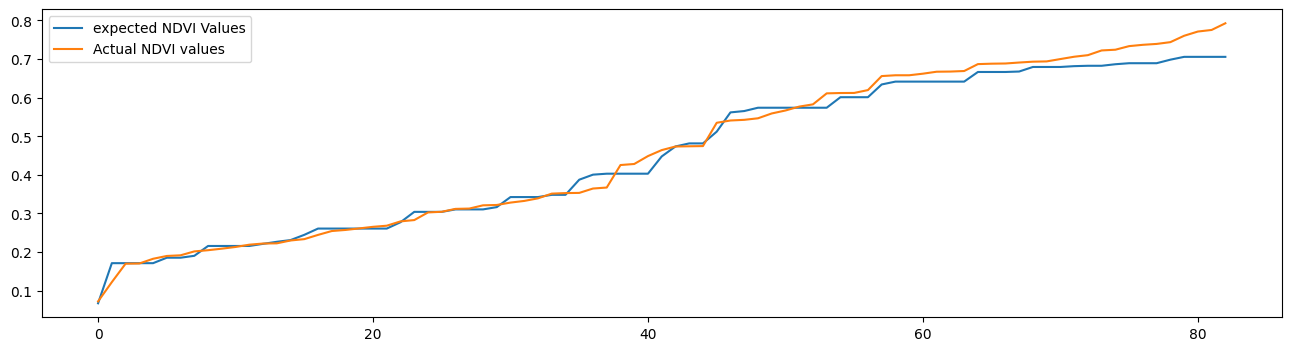

In [36]:
0#DecisionTree
import numpy as np
from sklearn.tree import DecisionTreeRegressor

# Load the NDVI data
# ndvi_data = np.loadtxt('updated_farm_records.csv', delimiter=',')

# Extract the NDVI values and dates
# ndvi_days = ndvi_data[:, 0]
# ndvi_values = ndvi_data[:, 1]
# print("X_train:\n", X_train, "y_train:\n", y_train)

# Fit a decision tree regression model to the historical data
reg = DecisionTreeRegressor().fit(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy())

# Use the model to predict the expected NDVI values for the given days
expected_ndvi_values = reg.predict(X_test.to_numpy().reshape(-1, 1))

# Set anomaly threshold
anomaly_threshold = 0.1

# Prompt user for current farm NDVI day and value
current_ndvi_day = int(input("Enter current NDVI day: "))
current_ndvi_value = float(input("Enter current NDVI value: "))
#current_ndvi_value = currNdvi

# Use the model to predict the expected NDVI value for the current day
expected_ndvi_value = reg.predict(np.array([current_ndvi_day]).reshape(-1, 1))[0]
print("expected_ndvi_value", expected_ndvi_value)

# Compute the residual between the predicted value and the actual value for the current day
residual = current_ndvi_value - expected_ndvi_value

# Check if the current NDVI value is anomalous or not
if np.abs(residual) > anomaly_threshold:
    print('Current NDVI value is anomalous')
else:
    print('Current NDVI value is not anomalous')

plt.plot(np.sort(expected_ndvi_values), label="expected NDVI Values")
plt.plot(np.sort(y_test), label="Actual NDVI values")
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import r2_score

print("accuracy = ", r2_score(y_test.to_numpy(), expected_ndvi_values))

accuracy =  0.8474909189951929
